In [1]:
# 1. Mount Google Drive and Load Dataset
#from google.colab import drive
#drive.mount('/content/drive')

import pandas as pd

#file_path = '/content/drive/MyDrive/Churn_Banking_Modeling_ENG.csv'
file_path = 'Churn_Banking_Modeling_ENG.csv'
df = pd.read_csv(file_path)
df.head()

,customer_id,flag_request_closure,amt_cust_value,flag_online_acc_opening,flag_mult_account_ownership,num_age,str_prov_domicile,str_prov_residence,num_year_first_account,str_profession,...,amt_current_liquidity,amt_current_managed,amt_current_administered,amt_6m_current_liquidity,amt_6m_current_managed,amt_6m_current_administered,flag_outgoing_sec_tranfer,flag_card_rejection,flag_loan_rejection,flag_deactivation_rid
0,2,no,65.03,0,0,38.0,BO,BO,2004.0,Impiegato,...,1634.57,2978.40,2980.92,1550.44,2853.2,2853.22,0,0,0,0
1,3,no,138.88,0,0,45.0,SA,SA,2000.0,Impiegato,...,11918.26,NaN,34916.15,26122.17,NaN,22053.82,0,0,0,0
2,4,no,546.54,0,0,61.0,VT,VT,2005.0,Altro/Nessuno,...,2671.95,NaN,232776.62,16545.25,NaN,216304.33,1,0,0,0
3,5,no,68.69,0,0,33.0,MI,MI,2010.0,Impiegato,...,19211.31,15013.53,15017.53,12500.00,NaN,NaN,0,0,0,0
4,7,no,2417.05,0,0,36.0,MI,MI,2001.0,Quadro,...,1526.38,NaN,NaN,1427.70,NaN,21514.60,0,0,0,0


In [2]:
# 2. Preprocess Dataset
import numpy as np

missing_ratio = df.isnull().mean()
df_clean = df.drop(columns=missing_ratio[missing_ratio > 0.6].index)

df_clean["flag_request_closure"] = df_clean["flag_request_closure"].map({"si": 1, "no": 0})

df_clean = df_clean.drop(columns=["customer_id", "str_profession", "str_prov_domicile", "str_prov_residence"], errors='ignore')

cat_cols = df_clean.select_dtypes(include="object").nunique()
low_card = cat_cols[cat_cols <= 10].index.tolist()

df_encoded = pd.get_dummies(df_clean, columns=low_card, drop_first=True)
df_encoded = df_encoded.fillna(df_encoded.median(numeric_only=True))

X = df_encoded.drop(columns="flag_request_closure")
y = df_encoded["flag_request_closure"]

In [3]:
# 3. Train/Test Split & Balancing
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

train_df = pd.concat([X_train, y_train], axis=1)
majority = train_df[train_df.flag_request_closure == 0]
minority = train_df[train_df.flag_request_closure == 1]
majority_down = resample(majority, replace=False, n_samples=len(minority)*5, random_state=42)

train_balanced = pd.concat([majority_down, minority])
X_train_bal = train_balanced.drop(columns="flag_request_closure")
y_train_bal = train_balanced["flag_request_closure"]

In [4]:
# 4. Train Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

dtc3 = DecisionTreeClassifier(min_samples_leaf=50, random_state=42)
dtc3.fit(X_train_bal, y_train_bal)

rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf.fit(X_train_bal, y_train_bal)

lr = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
lr.fit(X_train_bal, y_train_bal)

C:\Users\rtira\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

In [5]:
# 5. Evaluate Models
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

def evaluate_model(model, name):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    print(f"\n=== {name} ===")
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("AUC Score:", roc_auc_score(y_test, y_prob))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

evaluate_model(dtc3, "Decision Tree")
evaluate_model(rf, "Random Forest")
evaluate_model(lr, "Logistic Regression")


=== Decision Tree ===
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.98     75077
           1       0.05      0.32      0.08       397

    accuracy                           0.96     75474
   macro avg       0.52      0.64      0.53     75474
weighted avg       0.99      0.96      0.98     75474

AUC Score: 0.832414556487749
Confusion Matrix:
 [[72450  2627]
 [  270   127]]

=== Random Forest ===
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.98     75077
           1       0.07      0.40      0.11       397

    accuracy                           0.97     75474
   macro avg       0.53      0.68      0.55     75474
weighted avg       0.99      0.97      0.98     75474

AUC Score: 0.8762245069033912
Confusion Matrix:
 [[72835  2242]
 [  240   157]]

=== Logistic Regression ===
Classification Report:
               precision    recall  f1-sc

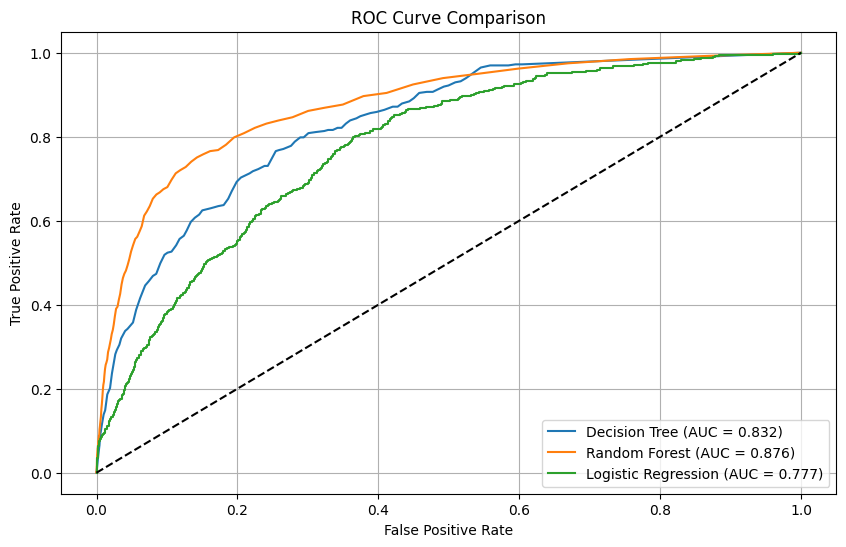

In [6]:
# 6. Plot ROC Curves
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

models = {'Decision Tree': dtc3, 'Random Forest': rf, 'Logistic Regression': lr}
plt.figure(figsize=(10, 6))

for name, model in models.items():
    y_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc_score(y_test, y_prob):.3f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.grid()
plt.show()

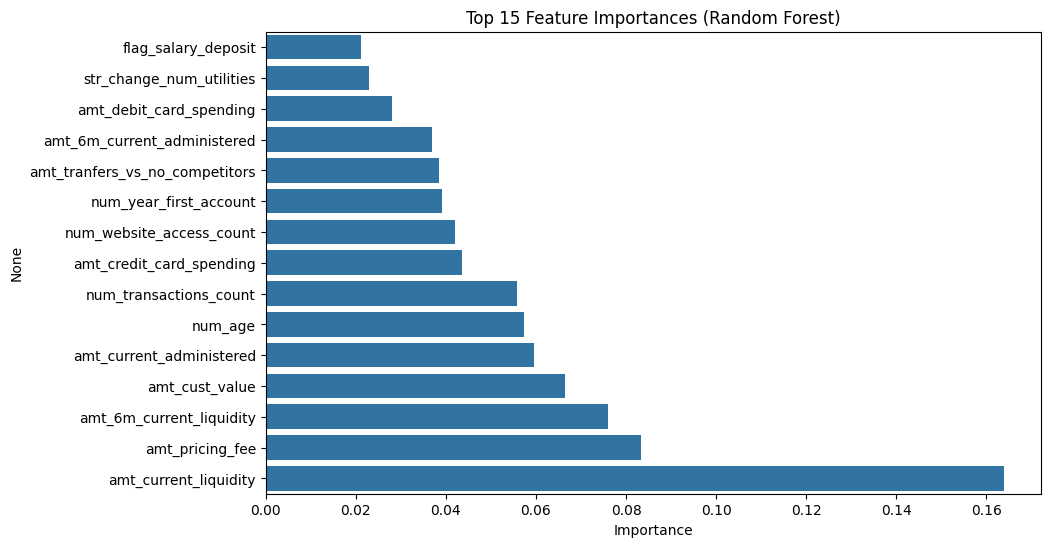

In [7]:
# 7. Feature Importance (Random Forest)
import seaborn as sns

importances = rf.feature_importances_
indices = np.argsort(importances)[-15:]  # Top 15 features
features = X.columns[indices]

plt.figure(figsize=(10, 6))
sns.barplot(x=importances[indices], y=features)
plt.title("Top 15 Feature Importances (Random Forest)")
plt.xlabel("Importance")
plt.show()